<a href="https://colab.research.google.com/github/SpideyFanDan/indie-comics-recommender-app/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Import necessary libraries
import requests
import pandas as pd
import time

# --- Configuration for Comic Vine API ---
API_KEY = '9e40e4c55612e17f6fe759727e738dada4bc723e'

# This creates the unique User-Agent header required by the API
HEADERS = {
    'User-Agent': 'IndieComicsRecommender-StudentProject/1.0 (dwittysmitty@gmail.com)'
}

API_BASE_URL = 'https://comicvine.gamespot.com/api'
MAJORS_TO_EXCLUDE = ['Marvel', 'DC Comics', 'Marti Comics']
TARGET_COUNT = 5000

# --- Main Script Logic ---
if __name__ == "__main__":
    all_volumes = []
    current_offset = 0

    print(f"Starting data collection from Comic Vine. Goal: {TARGET_COUNT} indie comics.")

    while len(all_volumes) < TARGET_COUNT:
        endpoint = f'{API_BASE_URL}/volumes'
        params = {
            'api_key': API_KEY,
            'format': 'json',
            'limit': 100,
            'offset': current_offset,
            'sort': 'date_added:desc'
        }

        print(f"Requesting data with offset {current_offset}...")

        try:
            response = requests.get(endpoint, params=params, headers=HEADERS)
            response.raise_for_status() # Raise an error for bad status codes
            data = response.json()
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            break

        if not data or not data.get('results'):
            print("No more data returned from API. Stopping.")
            break

        for volume in data['results']:
            publisher_name = volume.get('publisher', {}).get('name') if volume.get('publisher') else None

            if publisher_name and publisher_name not in MAJORS_TO_EXCLUDE:
                all_volumes.append({
                    'series_id': volume.get('id'),
                    'series_name': volume.get('name'),
                    'start_year': volume.get('start_year'),
                    'publisher': publisher_name,
                    'issue_count': volume.get('count_of_issues'),
                    'description': volume.get('deck')
                })

        print(f"Collected {len(all_volumes)} indie comics so far...")

        # Stop if we hit our target
        if len(all_volumes) >= TARGET_COUNT:
            print(f"Target of {TARGET_COUNT} reached. Stopping.")
            break

        current_offset += 100

        # Respect the API's rate limit. Wait 1 second between requests.
        time.sleep(1)

    df = pd.DataFrame(all_volumes)
    output_path = 'comicvine_comics.csv'
    df.to_csv(output_path, index=False)

    print("-" * 20)
    print(f"SUCCESS! Data for {len(df)} indie comic series saved to {output_path}")

Starting data collection from Comic Vine. Goal: 5000 indie comics.
Requesting data with offset 0...
Collected 80 indie comics so far...
Requesting data with offset 100...
Collected 154 indie comics so far...
Requesting data with offset 200...
Collected 231 indie comics so far...
Requesting data with offset 300...
Collected 323 indie comics so far...
Requesting data with offset 400...
Collected 411 indie comics so far...
Requesting data with offset 500...
Collected 511 indie comics so far...
Requesting data with offset 600...
Collected 595 indie comics so far...
Requesting data with offset 700...
Collected 693 indie comics so far...
Requesting data with offset 800...
Collected 779 indie comics so far...
Requesting data with offset 900...
Collected 856 indie comics so far...
Requesting data with offset 1000...
Collected 946 indie comics so far...
Requesting data with offset 1100...
Collected 1041 indie comics so far...
Requesting data with offset 1200...
Collected 1136 indie comics so fa

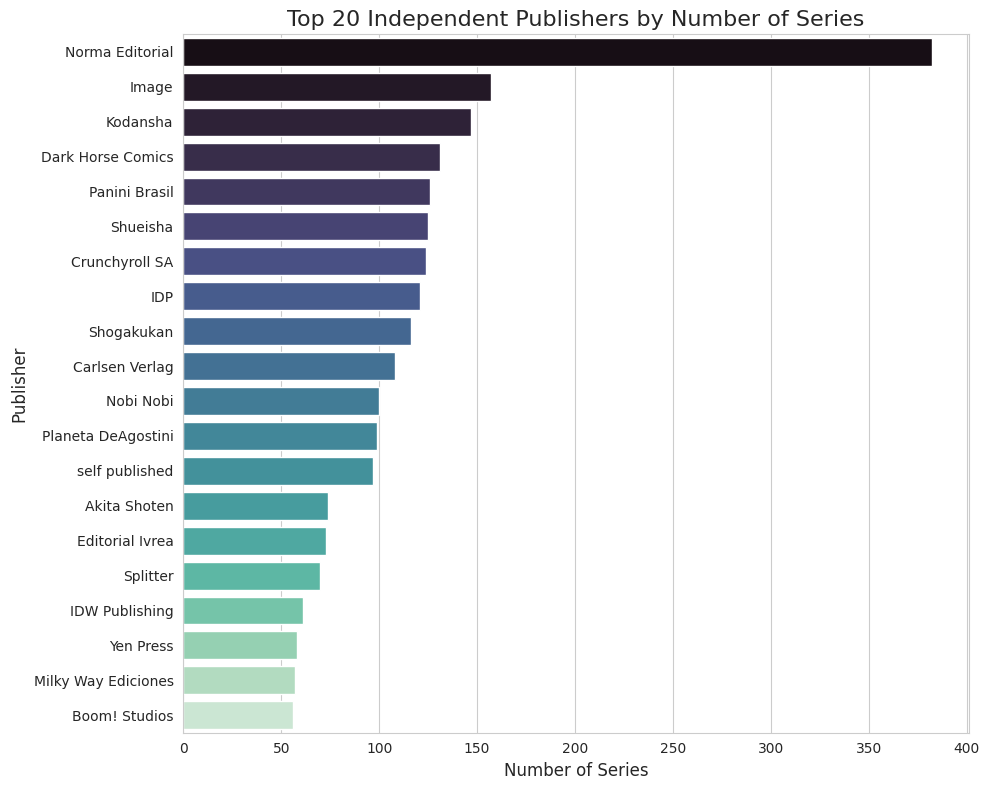

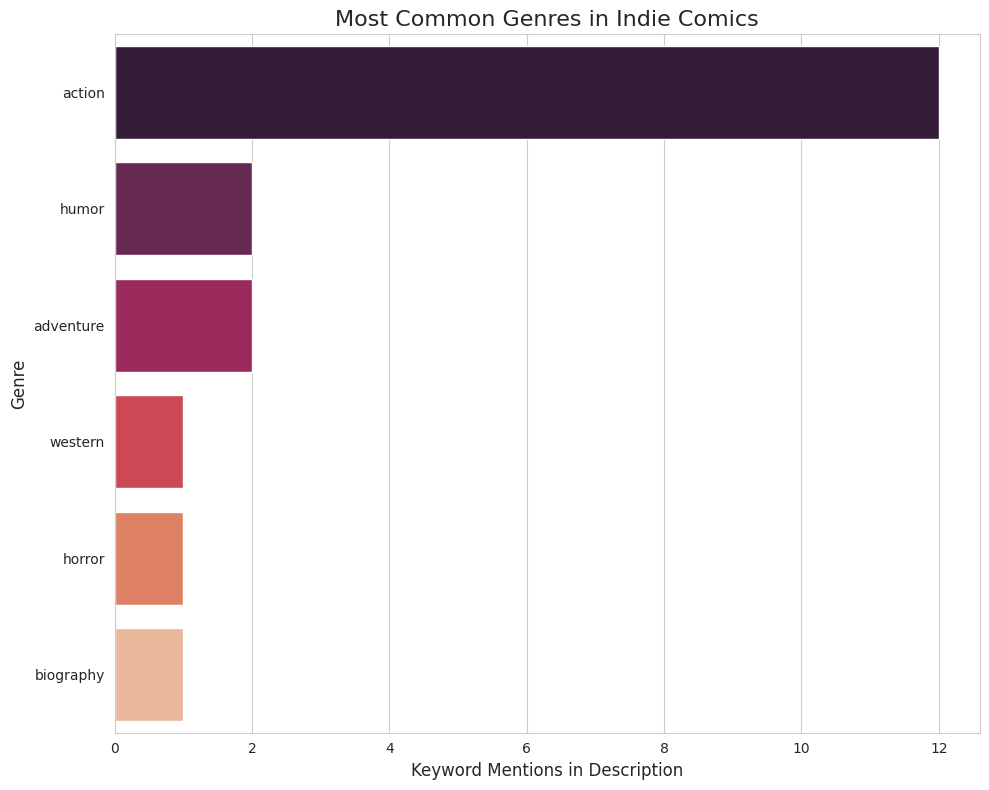

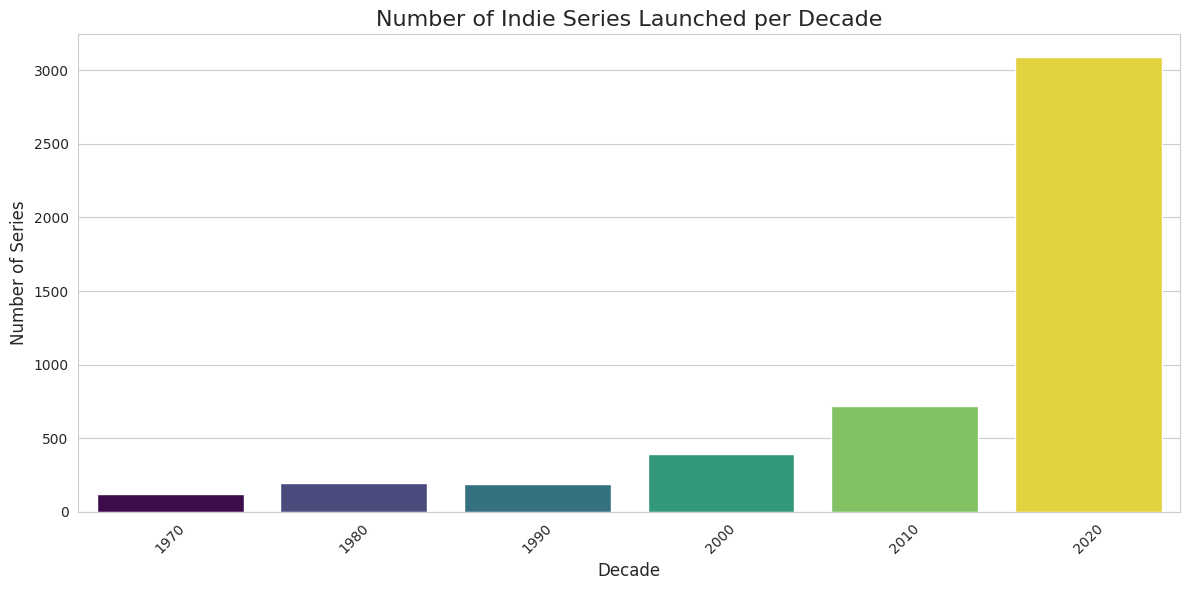

In [18]:
# === 1. Data Loading and Preparation ===

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Load the dataset collected from the API
df = pd.read_csv('comicvine_comics.csv')

# Preprocess the data by filling missing descriptions with an empty string.
# This prevents errors during text analysis later.
df['description'] = df['description'].fillna('')


# === 2. Feature Engineering: Genre Extraction ===

# Define a list of common genres to identify in comic book descriptions.
genre_list = [
    'sci-fi', 'science fiction', 'fantasy', 'horror', 'superhero', 'crime',
    'comedy', 'humor', 'drama', 'adventure', 'mystery', 'thriller',
    'romance', 'action', 'western', 'historical', 'biography'
]

# Use collections.Counter to efficiently count occurrences of each genre keyword.
genre_counts = Counter()

# Iterate through each series description to find and count genre keywords.
for desc in df['description']:
    # Find all non-overlapping matches for the genre keywords in the description (case-insensitive).
    found_genres = re.findall(r'\b(' + '|'.join(genre_list) + r')\b', desc.lower())
    genre_counts.update(found_genres)

# Convert the 15 most common genres into a DataFrame for plotting.
genre_df = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])


# === 3. Descriptive Visualizations ===

# Set the global aesthetic style for all plots.
sns.set_style('whitegrid')

# --- Visualization 1: Top 20 Publishers by Series Count ---
# This chart shows the market share of the most prolific independent publishers.
plt.figure(figsize=(10, 8))

# Isolate the top 20 publishers for a cleaner visualization.
top_publishers = df['publisher'].value_counts().head(20)

# Create the horizontal bar plot.
sns.barplot(x=top_publishers.values, y=top_publishers.index, hue=top_publishers.index, palette='mako', legend=False)

plt.title('Top 20 Independent Publishers by Number of Series', fontsize=16)
plt.xlabel('Number of Series', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.tight_layout()
plt.show()

# --- Visualization 2: Most Common Genres in Descriptions ---
# This chart visualizes the thematic landscape of the collected indie comics.
plt.figure(figsize=(10, 8))

# Create the horizontal bar plot from the genre counts.
sns.barplot(x='Count', y='Genre', data=genre_df, hue='Genre', palette='rocket', legend=False)

plt.title('Most Common Genres in Indie Comics', fontsize=16)
plt.xlabel('Keyword Mentions in Description', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

# --- Visualization 3: Indie Series Launches by Decade ---
# This chart shows historical trends in indie comic publishing.

# Prepare data for decade analysis.
df['start_year_numeric'] = pd.to_numeric(df['start_year'], errors='coerce')
# Create an independent copy to avoid SettingWithCopyWarning.
decade_df = df.dropna(subset=['start_year_numeric']).copy()
decade_df['start_year_numeric'] = decade_df['start_year_numeric'].astype(int)
# Calculate the decade using integer division.
decade_df['decade'] = (decade_df['start_year_numeric'] // 10) * 10

# Create the count plot.
plt.figure(figsize=(12, 6))

# Filter for recent decades to provide a more focused view.
filtered_by_decade = decade_df[decade_df['decade'] >= 1970]

sns.countplot(x='decade', data=filtered_by_decade, hue='decade', palette='viridis', legend=False)

plt.title('Number of Indie Series Launched per Decade', fontsize=16)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Series', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()